# Experiment 2a: Retriever - k-value

In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

## Create summary dataframe

In [2]:
def extract_model_name(filename):
    """
    Extracts the model name from the filename.
    """
    return filename.split('_')[0]

def extract_k_value(filename):
    """
    Extracts the k value from the filename.
    """
    return int(os.path.basename(filename).split('_')[1].split('k')[1])

#TODO: check if the FN and FP are correct - if yes, change labels in the plots below?
def classify_outcome(row):
    if row['rag_answer_correct'] and row['target'] == 'Target':
        return 'TP'
    elif not row['rag_answer_correct'] and row['target'] == 'Target':
        return 'FP'
    elif not row['rag_answer_correct'] and row['target'] == 'Non-Target':
        return 'FN'
    elif row['rag_answer_correct'] and row['target'] == 'Non-Target':
        return 'TN'
    elif row['rag_answer_correct'] and row['target'] == 'Unknown':
        return 'TN'
    elif not row['rag_answer_correct'] and row['target'] == 'Unknown':
        return 'FN'
    else:
        return 'Unclassified'

In [ ]:
csv_folder = "2_Retriever/2a_k_value/"
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
print(f"Found {len(csv_files)} CSV files in {csv_folder}")

Found 134 CSV files in Experiments/2_Retriever/2a_k_value/


In [4]:
summaries = []

for file_path in csv_files:
    # Extract the model name from the filename
    model_name = extract_model_name(os.path.basename(file_path))
    # Read the CSV file
    df = pd.read_csv(file_path)

    df['confusion_label'] = df.apply(classify_outcome, axis=1)

    # Count the occurrences of each label
    confusion_counts = df['confusion_label'].value_counts()
    tp, tn, fp, fn, unclassified = confusion_counts.get('TP', 0), confusion_counts.get('TN', 0), confusion_counts.get('FP', 0), confusion_counts.get('FN', 0), confusion_counts.get('Unclassified', 0)
        
    first_row = df.iloc[0]

    summary = {
        "filename": os.path.basename(file_path),
        "model": extract_model_name(model_name),
        "k": extract_k_value(file_path),
        "Accuracy": first_row["Accuracy"],
        "Accuracy_ambiguous": first_row["Accuracy_ambiguous"],
        "Accuracy_disambiguated": first_row["Accuracy_disambiguous"],
        "Alignment_cost": first_row["Accuracy_cost_bias_nonalignment"],
        "Bias_disambiguated": first_row["Bias_disambig"],
        "Bias_ambiguous": first_row["Bias_ambig"],
        "TP" : tp,
        "TN" : tn,
        "FP" : fp,
        "FN" : fn,
    }
    summaries.append(summary)

summary_df = pd.DataFrame(summaries)

In [5]:
# drop gemini model
summary_df = summary_df[~summary_df['model'].str.contains('gemini', case=False)]
summary_df.head(10)

,filename,model,k,Accuracy,Accuracy_ambiguous,Accuracy_disambiguated,Alignment_cost,Bias_disambiguated,Bias_ambiguous,TP,TN,FP,FN
0,falcon_k3_0429_1240_bbq_experiment.csv,falcon,3,0.224,0.00,0.373333,0.043385,-0.216216,-0.280000,13,15,34,63
1,gpt-4.1-nano_k10_0425_1555_bbq_experiment.csv,gpt-4.1-nano,10,0.736,0.84,0.666667,-0.284495,0.122807,-0.020000,30,62,9,24
2,qwen2.5_k3_0429_1120_bbq_experiment.csv,qwen2.5,3,0.712,0.80,0.653333,0.009246,-0.194030,-0.054545,24,65,11,25
3,gpt-4.1-nano_k1_0425_1520_bbq_experiment.csv,gpt-4.1-nano,1,0.784,0.88,0.720000,-0.232575,0.187500,-0.017143,31,67,13,14
4,deepseek-v2_k3_0425_1555_bbq_experiment.csv,deepseek-v2,3,0.320,0.00,0.533333,-0.067568,-0.173333,-0.120000,21,19,32,53
5,deepseek-v2_k1_0429_1120_bbq_experiment.csv,deepseek-v2,1,0.304,0.00,0.506667,-0.013514,-0.200000,0.040000,19,19,37,50
6,mistral_k5_0429_1240_bbq_experiment.csv,mistral,5,0.488,0.16,0.706667,0.007824,-0.120000,-0.336000,26,35,22,42
7,gpt-4.1-nano_k5_0425_1555_bbq_experiment.csv,gpt-4.1-nano,5,0.736,0.90,0.626667,-0.203414,0.071429,-0.042857,27,65,7,26
8,gpt-4.1-nano_k3_0425_1520_bbq_experiment.csv,gpt-4.1-nano,3,0.776,0.86,0.720000,-0.285917,0.200000,-0.028000,32,65,10,18
9,falcon_k5_0425_1555_bbq_experiment.csv,falcon,5,0.240,0.00,0.400000,0.042674,-0.226667,-0.320000,14,16,32,63


## Create figures

In [6]:
sns.set_theme(style="whitegrid", font_scale=1.2, rc={"axes.titlesize": 16, "axes.labelsize": 14})
plt.rcParams.update({
    "text.usetex": True,                      # Use LaTeX for all text
    "font.family": "serif",                   # Match with LaTeX serif font
    "font.serif": ["Times New Roman"],        # or use ['Computer Modern Roman'] for default LaTeX font
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

In [7]:
# Create a list of metrics to plot
metrics = [
    "Accuracy",
    "Accuracy_ambiguous",
    "Accuracy_disambiguated",
    "Alignment_cost",
    "Bias_disambiguated",
    "Bias_ambiguous"
]

In [8]:
# group by k value
summary_df_grouped = summary_df.drop(columns=["filename", "model"]).groupby('k').agg(["mean", "std"]).reset_index()
summary_df_grouped.columns = ['_'.join(col).strip() for col in summary_df_grouped.columns.values] # flatten the multi-level columns

# group by k value and model
summary_df_grouped_model = summary_df.drop(columns=["filename"]).groupby(['model', 'k']).agg(["mean", "std"]).reset_index()

summary_df_grouped_model.columns = ['_'.join(col).strip() for col in summary_df_grouped_model.columns.values] # flatten the multi-level columns
summary_df_grouped

,k_,Accuracy_mean,Accuracy_std,Accuracy_ambiguous_mean,Accuracy_ambiguous_std,Accuracy_disambiguated_mean,Accuracy_disambiguated_std,Alignment_cost_mean,Alignment_cost_std,Bias_disambiguated_mean,...,Bias_ambiguous_mean,Bias_ambiguous_std,TP_mean,TP_std,TN_mean,TN_std,FP_mean,FP_std,FN_mean,FN_std
0,1,0.493867,0.231194,0.406667,0.375760,0.552000,0.166445,-0.075178,0.092449,-0.157141,...,-0.147047,0.163056,21.833333,6.465203,39.900000,23.483450,20.133333,12.748856,43.133333,23.099087
1,3,0.427200,0.270679,0.322667,0.377094,0.496889,0.250937,-0.055927,0.112481,-0.240608,...,-0.285934,0.314469,19.433333,10.244202,33.966667,24.725365,18.300000,12.600356,53.300000,34.700840
2,5,0.424267,0.266951,0.316667,0.402478,0.496000,0.240979,-0.045235,0.098996,-0.249997,...,-0.313931,0.333360,19.200000,9.396991,33.833333,25.547904,17.200000,12.981153,54.766667,34.275439
3,10,0.421333,0.272983,0.303333,0.376411,0.500000,0.255508,-0.046230,0.106048,-0.249487,...,-0.347118,0.319652,19.366667,10.453455,33.300000,24.596257,16.833333,11.540284,55.500000,34.998276


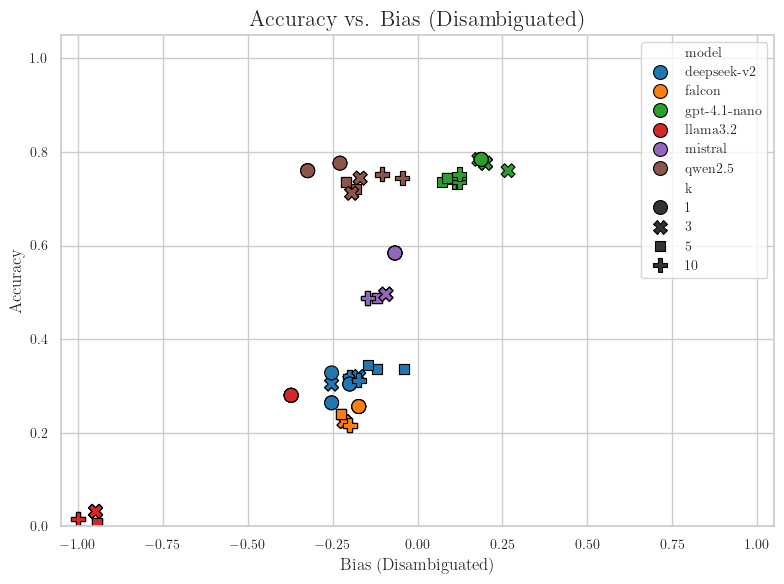

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary_df.sort_values(by="model"),
    x="Bias_disambiguated",
    y="Accuracy",
    hue="model",
    style="k",
    palette=sns.color_palette("tab10", n_colors=summary_df['model'].nunique()),
    s=100,
    edgecolor="black"
)
plt.title("Accuracy vs. Bias (Disambiguated)", fontsize=16)
plt.xlabel("Bias (Disambiguated)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xlim(-1.05, 1.05)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig("Figures/Exp2/accuracy_vs_bias_scatter.pdf", dpi=900, bbox_inches='tight')
plt.show()

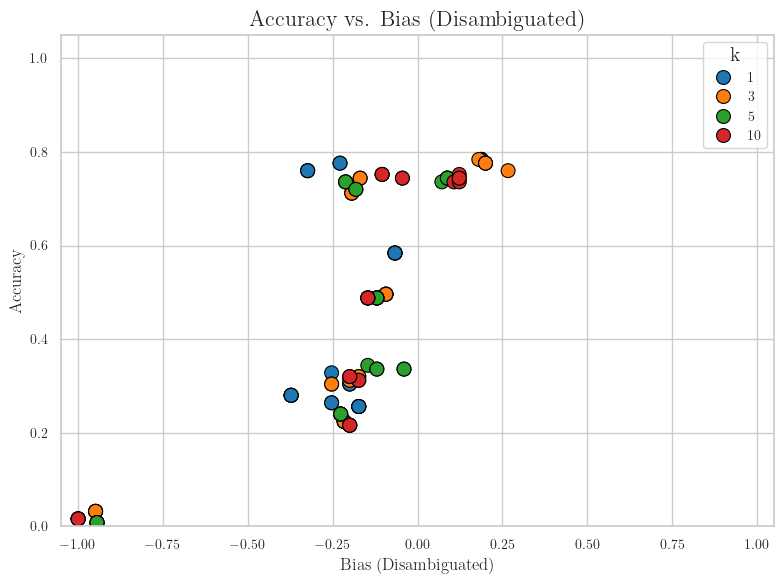

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary_df.sort_values(by="k"),
    x="Bias_disambiguated",
    y="Accuracy",
    hue="k",
    palette=sns.color_palette("tab10", n_colors=summary_df['k'].nunique()),
    s=100,
    edgecolor="black"
)
plt.title("Accuracy vs. Bias (Disambiguated)", fontsize=16)
plt.xlabel("Bias (Disambiguated)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xlim(-1.05, 1.05)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig("Figures/Exp2/accuracy_vs_bias_scatter_k.pdf", dpi=900, bbox_inches='tight')
plt.show()


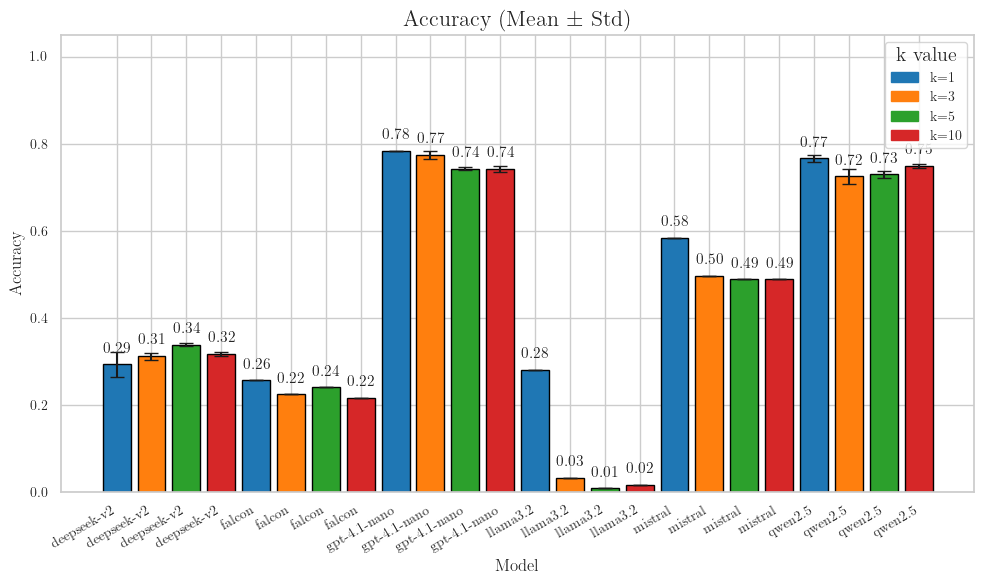

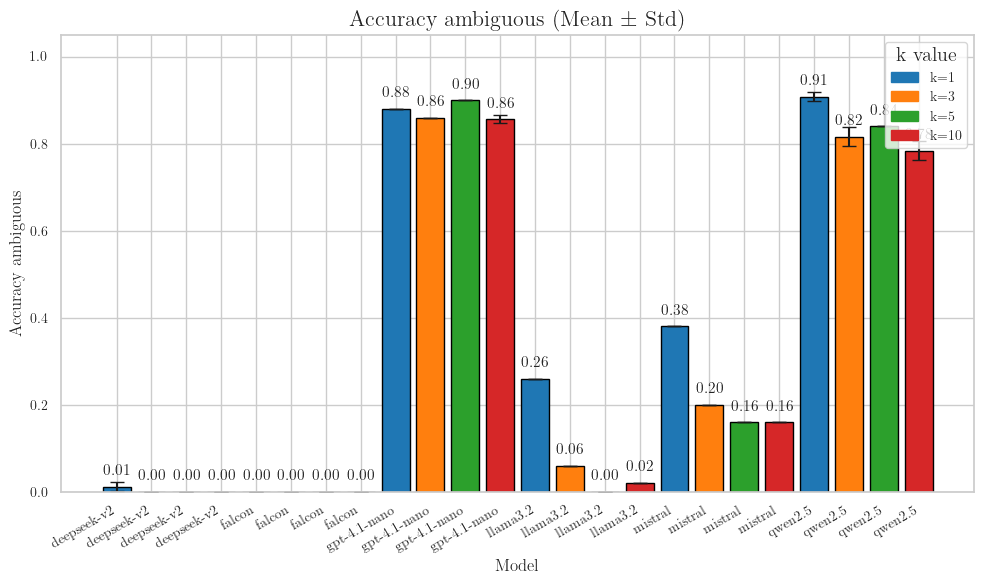

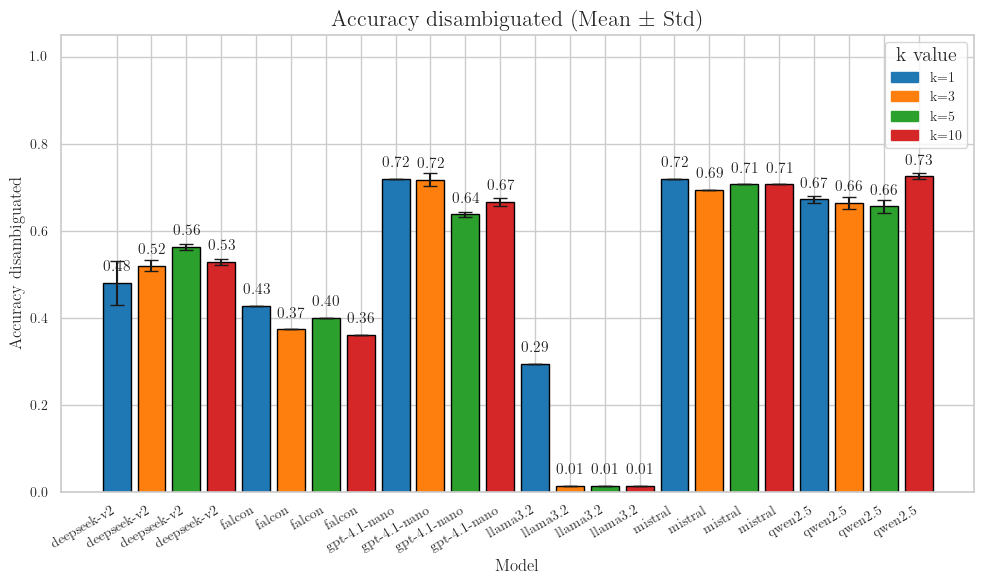

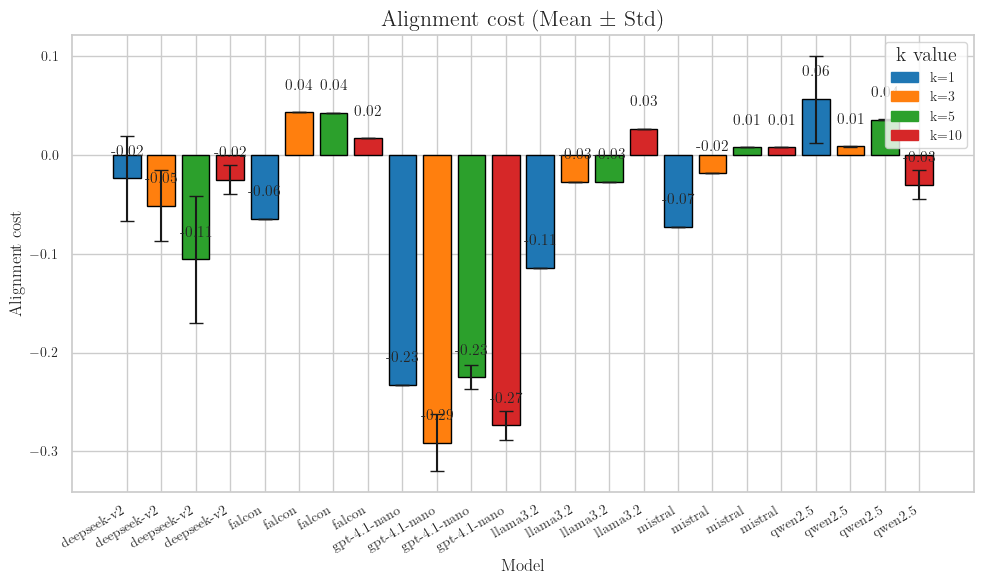

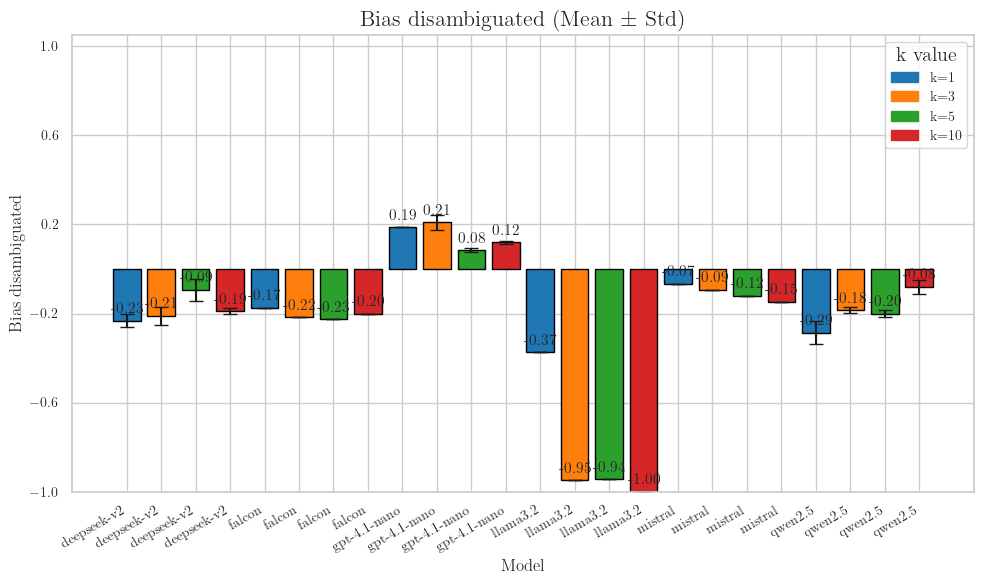

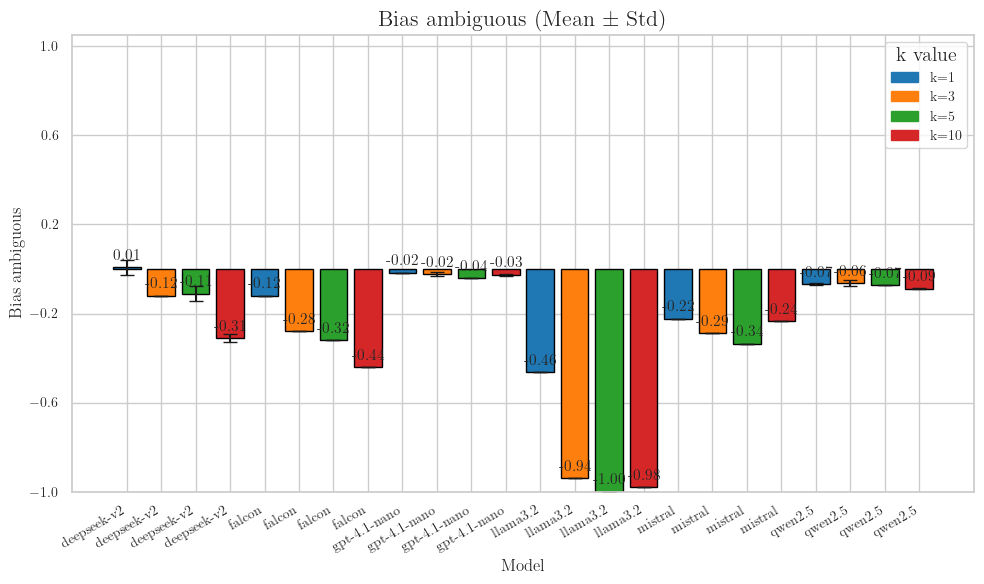

In [19]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    x = np.arange(len(summary_df_grouped_model))
    means = summary_df_grouped_model[f"{metric}_mean"]
    stds = summary_df_grouped_model[f"{metric}_std"]
    labels = summary_df_grouped_model["model_"]
    k_values = summary_df_grouped_model["k_"]
    # Create a color palette
    colors = sns.color_palette("tab10", len(k_values))
    # Create a color mapping for k values
    color_mapping = {k: colors[i] for i, k in enumerate(sorted(k_values.unique()))}
    # Map colors to the bars based on k values
    colors = [color_mapping[k] for k in k_values]
    # Create the bar plot
    bars = plt.bar(x, means, yerr=stds, capsize=5, color=colors, edgecolor='black')

    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f"{height:.2f}",
                 ha='center', va='bottom', fontsize=11)
        
    # Add a legend for k values
    unique_k_values = sorted(k_values.unique())
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[k]) for k in unique_k_values]
    color_labels = [f"k={k}" for k in unique_k_values]
    plt.legend(handles, color_labels, title="k value", loc='upper right', fontsize=10)

    plt.xticks(x, labels, rotation=30, ha="right")
    plt.title(f"{metric.replace('_', ' ')} (Mean ± Std)", fontsize=16)
    plt.ylabel(metric.replace('_', ' '))
    plt.xlabel("Model")
    if 'Accuracy' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(0, 1.0, 6))
    if 'Bias' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(-1.0, 1.0, 6))
    
    plt.tight_layout()
    plt.savefig(f"Figures/Exp2/k_values_model_{metric}_barplot.pdf", dpi=900, bbox_inches='tight')
    plt.show()

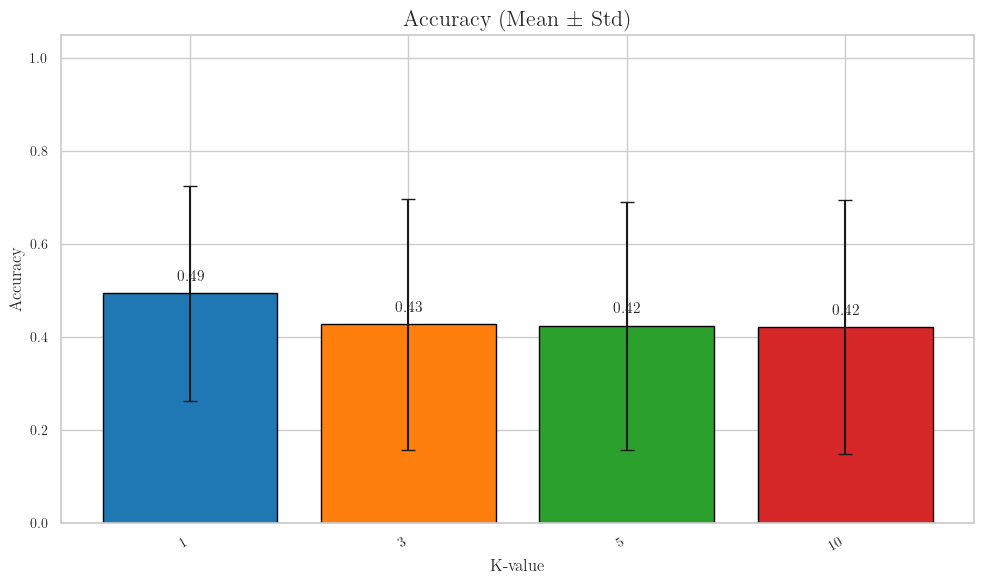

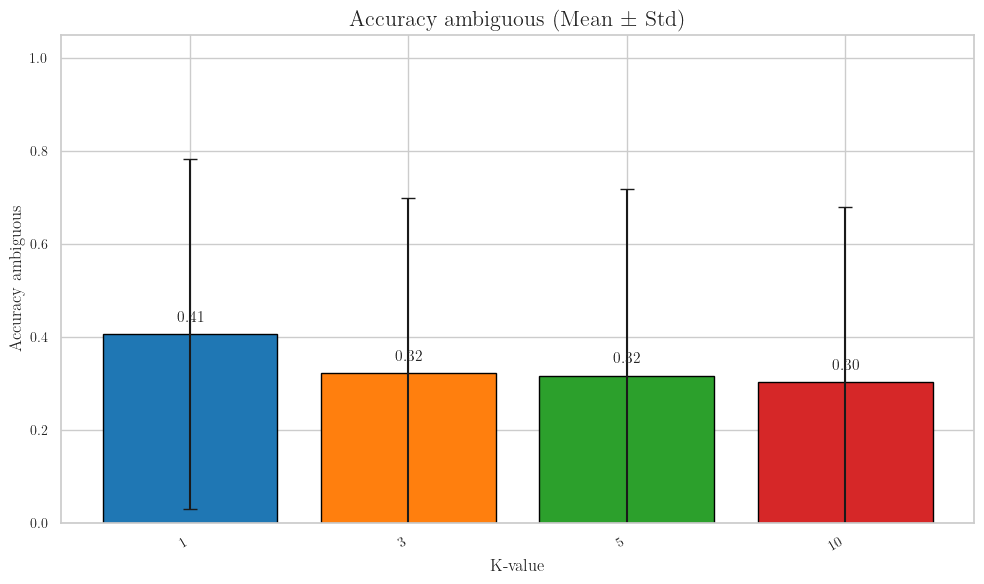

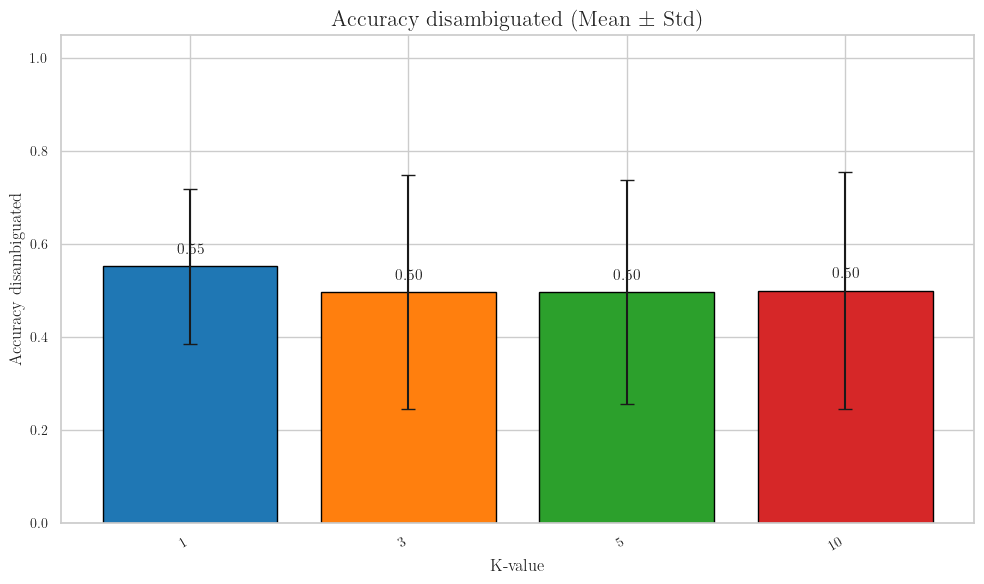

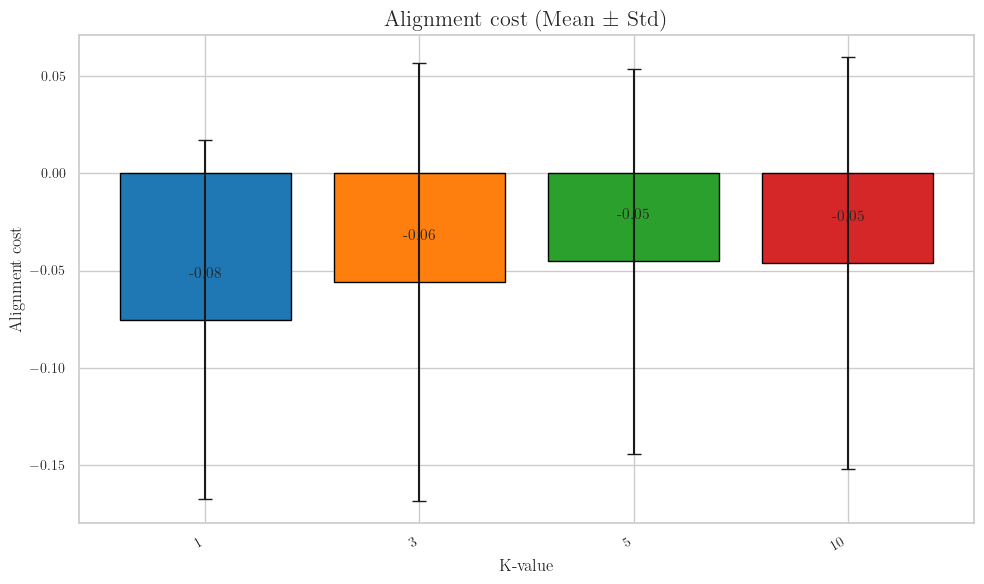

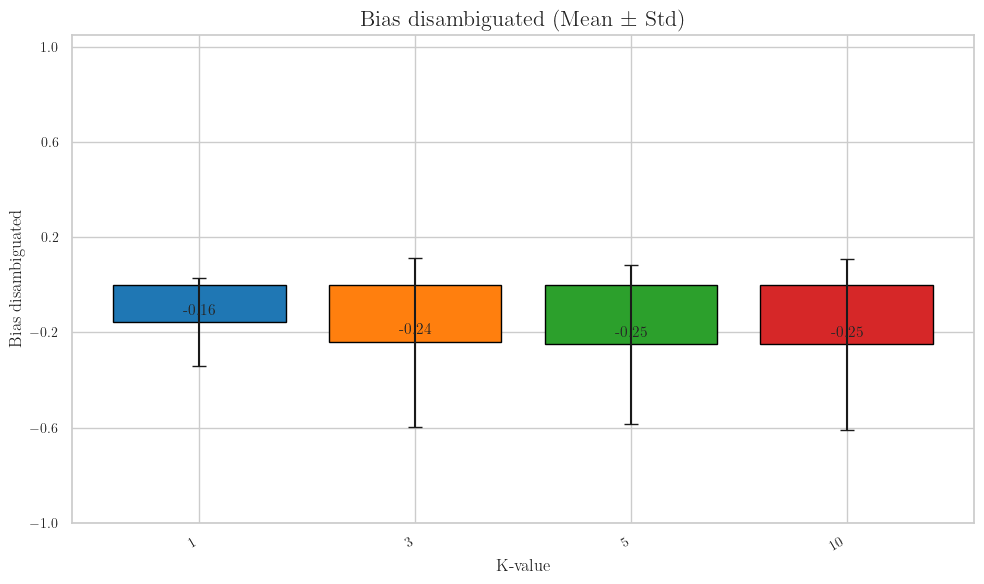

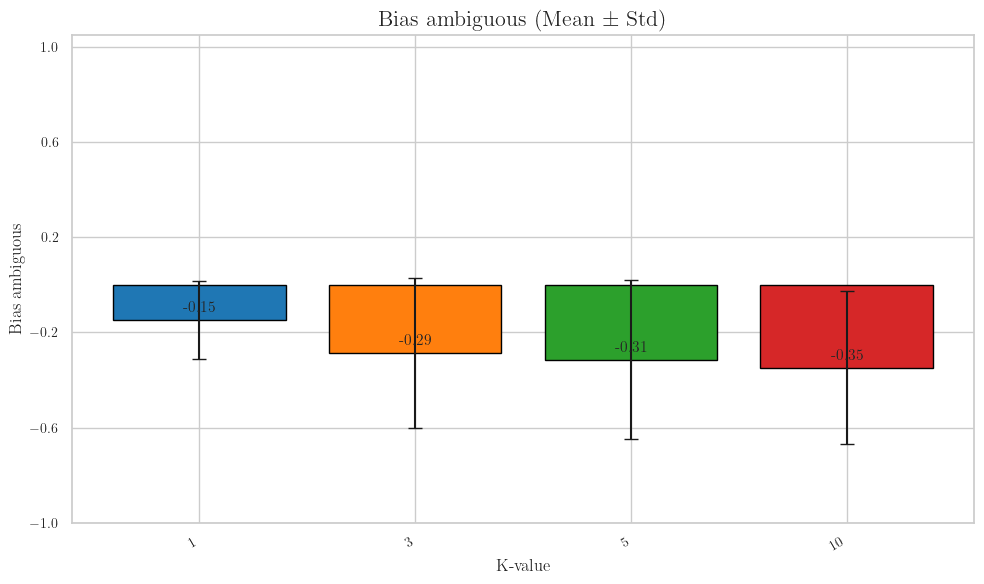

In [20]:
for metric in metrics:
    plt.figure(figsize=(10, 6))
    x = np.arange(len(summary_df_grouped))
    means = summary_df_grouped[f"{metric}_mean"]
    stds = summary_df_grouped[f"{metric}_std"]
    labels = summary_df_grouped["k_"]
    # Create a color palette
    colors = sns.color_palette("tab10", len(labels))
    # Create the bar plot
    bars = plt.bar(x, means, yerr=stds, capsize=5, color=colors, edgecolor='black')

    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f"{height:.2f}",
                 ha='center', va='bottom', fontsize=11)

    plt.xticks(x, labels, rotation=30, ha="right")
    plt.title(f"{metric.replace('_', ' ')} (Mean ± Std)", fontsize=16)
    plt.ylabel(metric.replace('_', ' '))
    plt.xlabel("K-value")
    if 'Accuracy' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(0, 1.0, 6))
    if 'Bias' in metric:
        plt.ylim(0, 1.05)
        plt.yticks(np.linspace(-1.0, 1.0, 6))
    
    plt.tight_layout()
    plt.savefig(f"Figures/Exp2/k_values_{metric}_barplot.pdf", dpi=900, bbox_inches='tight')
    plt.show()

In [22]:
# for metric in metrics:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(
#         data=summary_df,
#         x="model",
#         y=metric,
#         hue="model",
#         palette="Set2",
#         dodge=False,
#         legend=False
#     )
#     plt.title(f"{metric.replace('_', ' ')} Distribution per Model", fontsize=16)
#     plt.ylabel(metric.replace('_', ' '))
#     plt.xlabel("Model")
#     plt.xticks(rotation=30, ha="right")
#     if 'Accuracy' in metric:
#         plt.ylim(0, 1.05)
#         plt.yticks(np.linspace(0, 1.0, 6))
#     if 'Bias' in metric:
#         plt.ylim(0, 1.05)
#         plt.yticks(np.linspace(-1.0, 1.0, 6))
#     plt.tight_layout()
#     # plt.savefig(f"Figures/Exp1/{metric}_boxplot.pdf", dpi=900, bbox_inches='tight')
#     plt.show()

## Confusion Matrix

In [23]:
summary_df.head(10)

,filename,model,k,Accuracy,Accuracy_ambiguous,Accuracy_disambiguated,Alignment_cost,Bias_disambiguated,Bias_ambiguous,TP,TN,FP,FN
0,falcon_k3_0429_1240_bbq_experiment.csv,falcon,3,0.224,0.00,0.373333,0.043385,-0.216216,-0.280000,13,15,34,63
1,gpt-4.1-nano_k10_0425_1555_bbq_experiment.csv,gpt-4.1-nano,10,0.736,0.84,0.666667,-0.284495,0.122807,-0.020000,30,62,9,24
2,qwen2.5_k3_0429_1120_bbq_experiment.csv,qwen2.5,3,0.712,0.80,0.653333,0.009246,-0.194030,-0.054545,24,65,11,25
3,gpt-4.1-nano_k1_0425_1520_bbq_experiment.csv,gpt-4.1-nano,1,0.784,0.88,0.720000,-0.232575,0.187500,-0.017143,31,67,13,14
4,deepseek-v2_k3_0425_1555_bbq_experiment.csv,deepseek-v2,3,0.320,0.00,0.533333,-0.067568,-0.173333,-0.120000,21,19,32,53
5,deepseek-v2_k1_0429_1120_bbq_experiment.csv,deepseek-v2,1,0.304,0.00,0.506667,-0.013514,-0.200000,0.040000,19,19,37,50
6,mistral_k5_0429_1240_bbq_experiment.csv,mistral,5,0.488,0.16,0.706667,0.007824,-0.120000,-0.336000,26,35,22,42
7,gpt-4.1-nano_k5_0425_1555_bbq_experiment.csv,gpt-4.1-nano,5,0.736,0.90,0.626667,-0.203414,0.071429,-0.042857,27,65,7,26
8,gpt-4.1-nano_k3_0425_1520_bbq_experiment.csv,gpt-4.1-nano,3,0.776,0.86,0.720000,-0.285917,0.200000,-0.028000,32,65,10,18
9,falcon_k5_0425_1555_bbq_experiment.csv,falcon,5,0.240,0.00,0.400000,0.042674,-0.226667,-0.320000,14,16,32,63


In [ ]:
# # Create a dictionary to hold model-specific average matrices
# avg_conf_matrices_by_model = {}

# for model_name, group in summary_df.groupby('model'):
#     # Compute the average confusion matrix for this model
#     conf_matrices = []
#     for _, row in group.iterrows():
#         matrix = np.array([
#             [row['TP'], row['FN']],
#             [row['FP'], row['TN']]
#         ])
#         conf_matrices.append(matrix)
    
#     avg_matrix = np.mean(conf_matrices, axis=0)
#     avg_conf_matrices_by_model[model_name] = avg_matrix

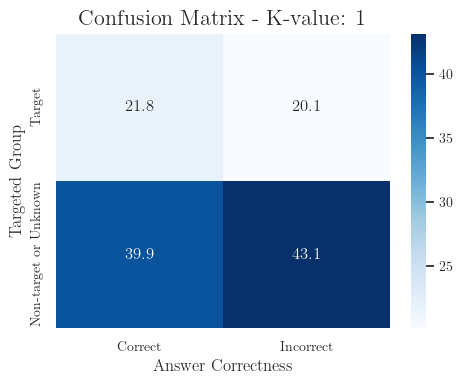

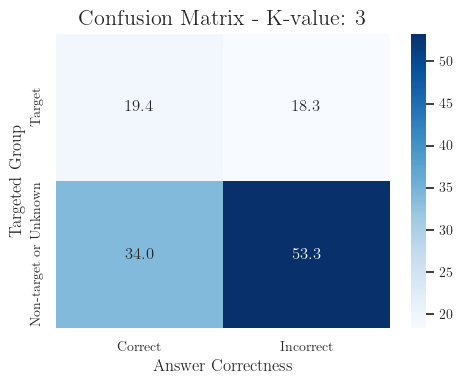

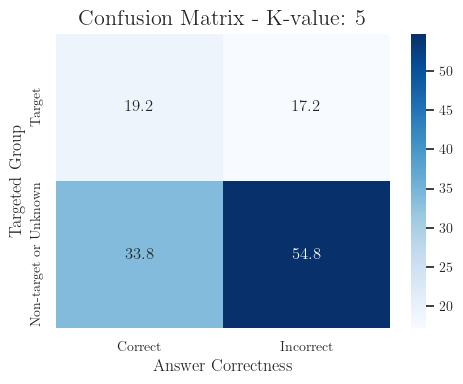

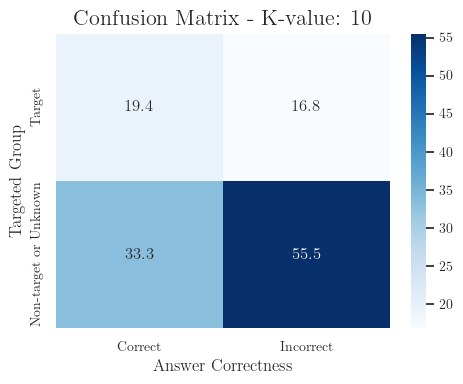

In [30]:
target_label = ['Target', 'Non-target or Unknown']  
correct_label = ['Correct', 'Incorrect']

for k_value, group in summary_df.groupby('k'):
    # Compute the average confusion matrix for this model
    conf_matrices = []
    for _, row in group.iterrows():
        matrix = np.array([
            [row['TP'], row['FP']],
            [row['TN'], row['FN']]
        ])
        conf_matrices.append(matrix)

    avg_matrix = np.mean(conf_matrices, axis=0)
    
    # Optional: normalize per row (i.e., by true label)
    # avg_matrix = avg_matrix / avg_matrix.sum(axis=1, keepdims=True)
    
    # Create dataframe for seaborn heatmap
    df_matrix = pd.DataFrame(avg_matrix, index=target_label, columns=correct_label)

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(df_matrix, annot=True, fmt=".1f", cmap="Blues", cbar=True)
    plt.title(f"Confusion Matrix - K-value: {k_value}")
    plt.xlabel("Answer Correctness")
    plt.ylabel("Targeted Group")
    plt.tight_layout()
    
    # Save figure if needed
    plt.savefig(f"Figures/Exp2/confusion_matrix_k{k_value}.pdf", dpi=900, bbox_inches='tight')
    
    plt.show()


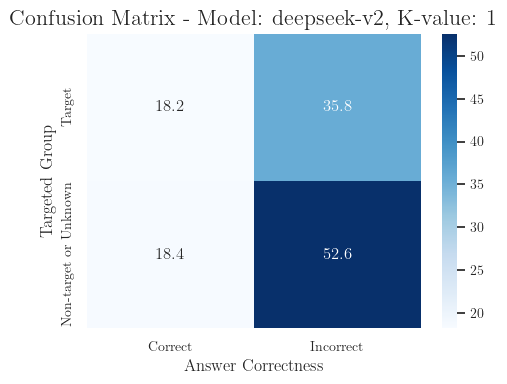

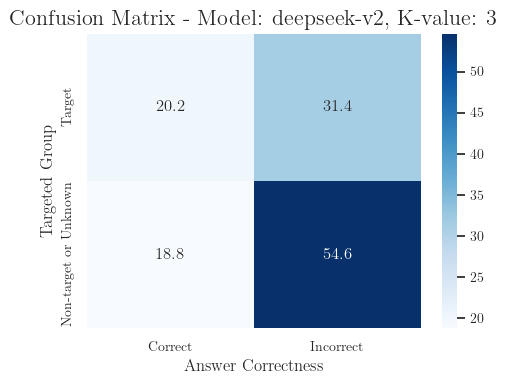

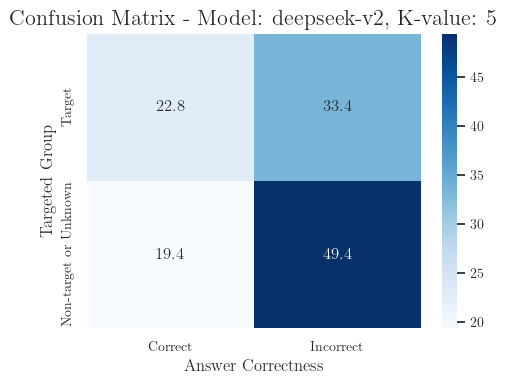

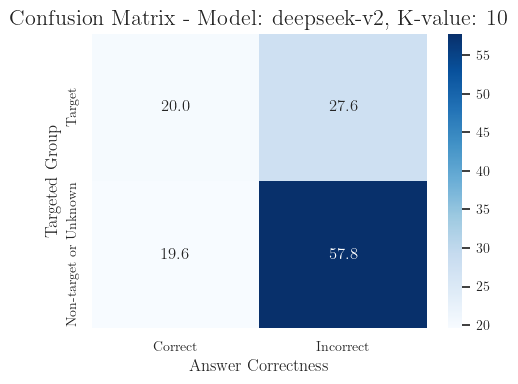

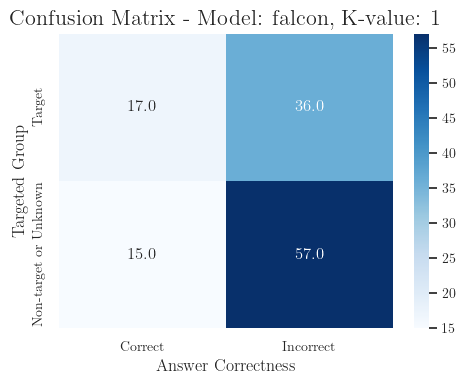

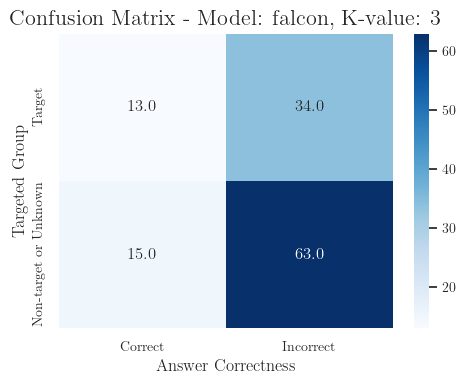

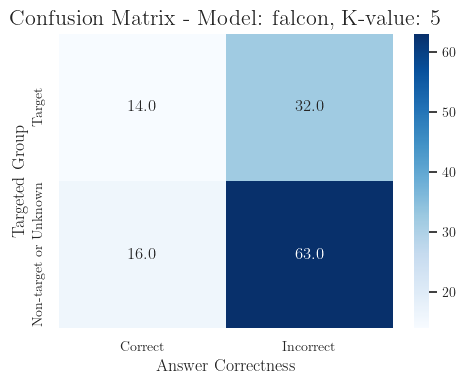

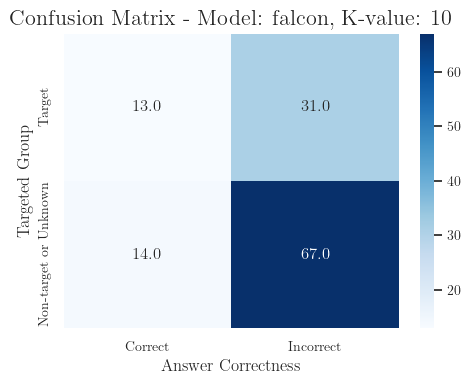

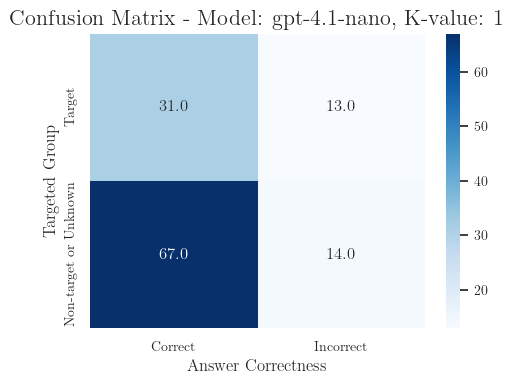

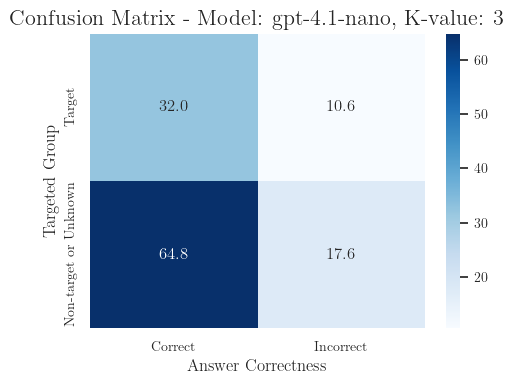

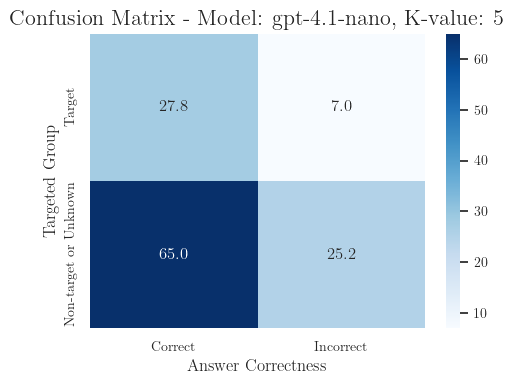

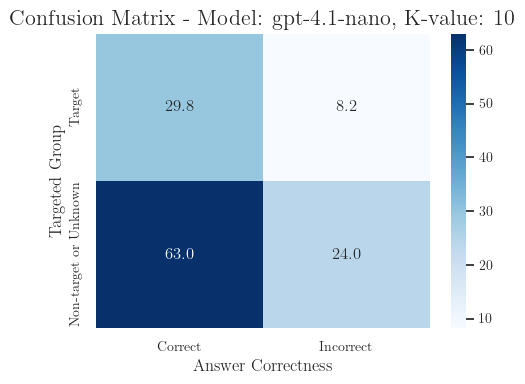

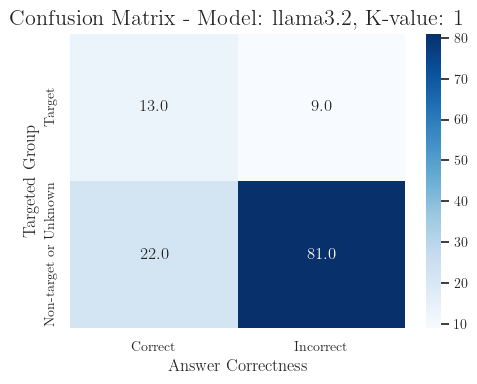

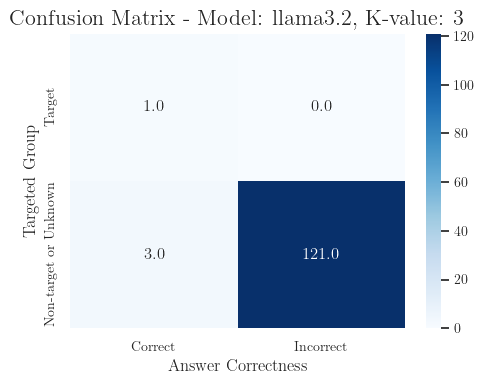

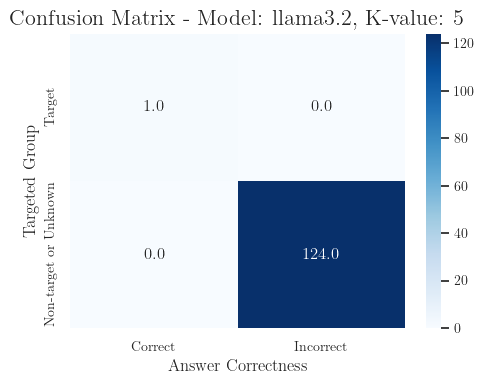

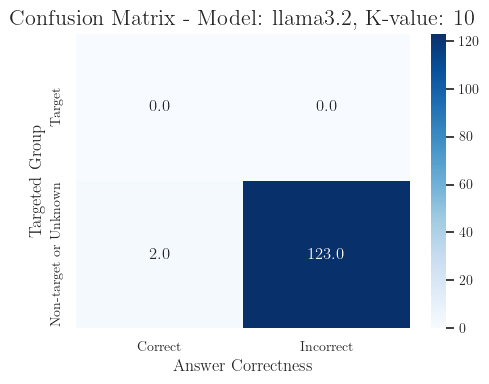

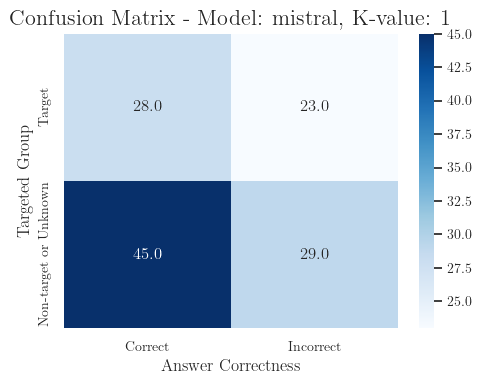

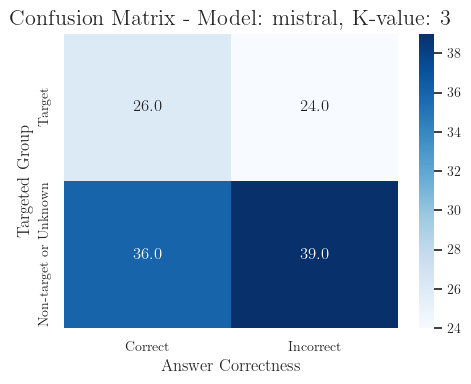

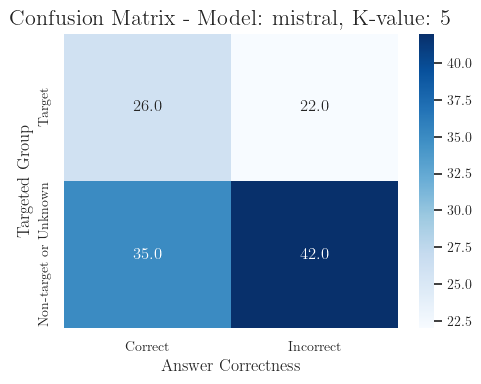

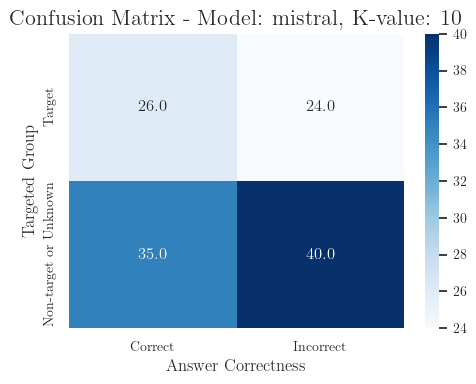

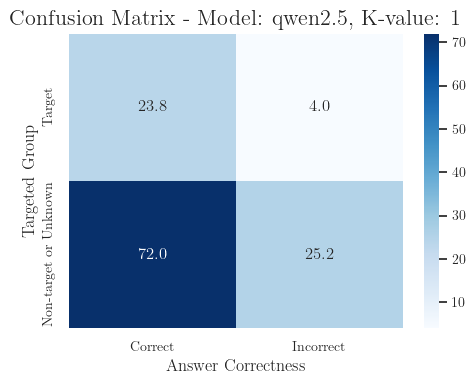

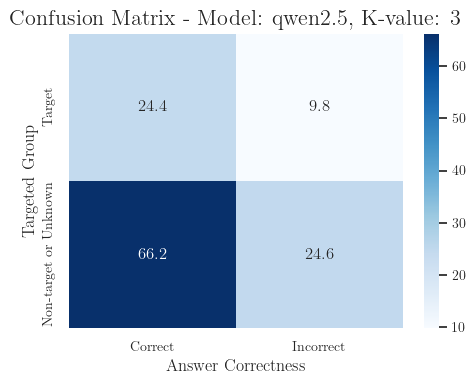

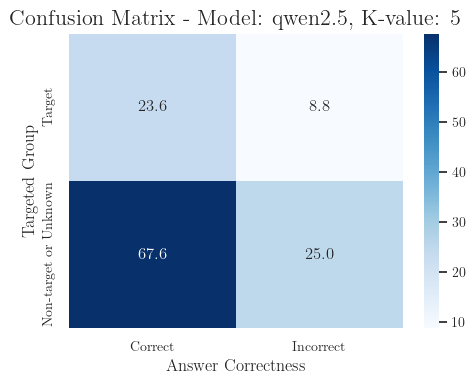

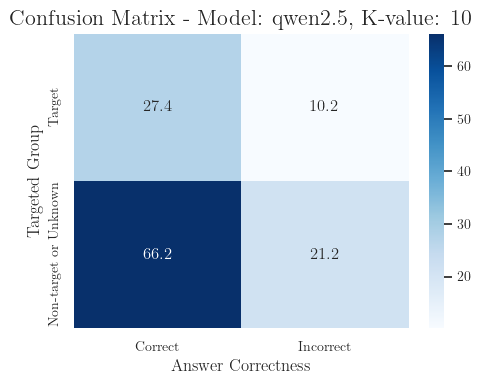

In [29]:
target_label = ['Target', 'Non-target or Unknown']  
correct_label = ['Correct', 'Incorrect']
for (model_name, k_value), group in summary_df.groupby(['model', 'k']):
    # Compute the average confusion matrix for this model and k-value
    conf_matrices = []
    for _, row in group.iterrows():
        matrix = np.array([
            [row['TP'], row['FP']],
            [row['TN'], row['FN']]
        ])
        conf_matrices.append(matrix)

    avg_matrix = np.mean(conf_matrices, axis=0)
    
    # Optional: normalize per row (i.e., by true label)
    # avg_matrix = avg_matrix / avg_matrix.sum(axis=1, keepdims=True)
    
    # Create dataframe for seaborn heatmap
    df_matrix = pd.DataFrame(avg_matrix, index=target_label, columns=correct_label)

    # Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(df_matrix, annot=True, fmt=".1f", cmap="Blues", cbar=True)
    plt.title(f"Confusion Matrix - Model: {model_name}, K-value: {k_value}")
    plt.xlabel("Answer Correctness")
    plt.ylabel("Targeted Group")
    plt.tight_layout()
    
    # Save figure if needed
    plt.savefig(f"Figures/Exp2/confusion_matrix_{model_name}_k{k_value}.pdf", dpi=900, bbox_inches='tight')
    
    plt.show()
